In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time

Goal represent solid matrix of magnesium that is alloyed with varying concentrations of aluminum.
See how certain properties change, such as Tm, Cp, etc.. when the conc. of Al is changed.

Challenges:
    - If we want to see transition from solid to liquid, we need a system that can represent both phases
        - A box in a box?  A square piece of solid in a larger square container.
        - Tm is reached once the square solid starts to separate and fill the larger container.

Variables:
    - Container dimensions: L 
    - Solid Mg alloy dimensions: D 
    - Total number of particles in the system: N
    - Concentration of Al: Xal
    - Mg-Mg interaction potential: Epsilon_Mg
    - Al-Al interaction potential: Epsilon_Al
    - Mg-Al interaction potential: Epsilon_MgAl
    - Temperature: T
    - Number of simulation steps: steps

Functions:
    - Create system: Build array of container size and populated the positions of the solid block
    - Calculate Energy:  Find the PE of the system of a given configuration
    - Trial Move: Select particle to move, accept or reject
        - Should include qualification to be able to move outside of the solid block dimensions
 

    

In [20]:
def site_coordinates(sys_array,atom): # atom should be 'Al' or 'Mg' - Must have the ' ' 
    
    # We use the np.where(array == something) to find all positions of a specific atom type
    # This returns a list of 3 arrays that groups all of the x values together, and same with y and z.
        # Ex. [[x1,x2,x3],[y1,y2,y3],[z1,z2,z3]]
    # This isn't really useful for pulling out a coordinate (x,y,z)
    # We need the (x,y,z) coordinates to find the element (value) of a single site in an array
    # This function turns the list of arrays, into a list of site coordinates
    # This process will come up a bit such as trial moves, calculating energy, etc..
    
    if atom == 'Mg':
        arg = 1
    elif atom == 'Al':
        arg = 2
    else:
        arg = 0
    
    sites = np.where(sys_array == arg) # makes list of arrays, grouping each coordinate type together 
    x,y,z = sites # List consists of 3 elements (each array).  Each is assigned its own variable.
    coordinates = list(zip(x,y,z)) # zip combines the nth term of all 3 arrays into a single coordinate
                                    # Ex.) [(x1,y1,z1), (x2,y2,z2), (x3,y3,z3)]
    
    return coordinates


def create_system (D,XAl,mixed):
    
    Ntot = D**3  # All lattice sites of the solid will be occupied
    NAl = int(Ntot*XAl) # Total number of Al atoms
    NMg = Ntot-NAl # Total number of Mg atoms
    
    matl_array = np.ones((D,D,D), dtype=np.uint8) # Creates the initial "block" of material. 3D array of ones
    shape = matl_array.shape # Stores the shape of the original 3D array in a variable
    mask = matl_array.flatten() # Makes the 3D array 1D.  Easier to replace values this way
    mask[0:NAl] = 2 # Replaces a certain amount of 1s in the 1D array with 2s - Function of the conc of Al
    if mixed == 'y':
        np.random.shuffle(mask) # Shuffles the 1D array, so that the 1s and 2s are randomly dispersed
    else:  # Doesn't mix the 1s and 2s.  We start with an unmixed system.
        pass
    matl_array = mask.reshape(shape) # Turns the 1D array back into a 3D array
    
    matl_array = np.pad(array=matl_array, pad_width=((D//2,D//2), (D//2,D//2),(1,D-1)), mode='constant', constant_values = 0)
        # Increases the space around the material, creating the "box".
        # Set up to be twice as large as the block of material
            
    box = (D*2) - 1 # Sets the box height
    matl_array[:,:,0] = 4  # Creates the floor
    matl_array[:,:,box] = 4  # Creates the ceiling
    
    Alsites = np.where(matl_array == 2) # We still need the sites in this format for graphing
    Mgsites = np.where(matl_array == 1)
    Alcoords = site_coordinates(matl_array, 'Al') # The coords will be used for looking up values in the array
    Mgcoords = site_coordinates(matl_array, 'Mg') # 
    
    return matl_array, Alsites, Mgsites, Alcoords, Mgcoords


def neighbors(atom_site, sys_array):

    # This func. takes in any single atom site (x,y,z) coordinate, an the system array
    # Returns the coordinates of all 6 neighbors (front,back,left,right,up,down)
    # Retruns a list of coordinates.
    # The goal is to use that list to find the element (value) at each coordinate site
    # With the values of all neighbors, we can calculate the local energy (length of 1) of any site
    
    neighbor_list = [] # Empty list - will eventually contain all 6 trips of coordinate values
    for i, coordinate in enumerate(["x", "y", "z"]):
        for num in [1,-1]:
            blank = np.zeros(3) # 1D array of 3 zeros
            blank[i] = num # change the coordinate of interest to a 1 or -1. All others stay 0
            new_cord = blank+atom_site # Add the blank array to the atom_site array of coordinates
                                        # Only changes one of the coordinates by 1 or -1, others stay the same
            new_cord = tuple(new_cord) # Change the new_cord array to a tuple data type
            neighbor_list.append(new_cord) # Add the tuple to the list of neighbors above
    
    
    return neighbor_list


def initial_energy(sys_array, D, epAl, epMg, epAlMg, epSurface):
    
    # We can just calculate what the initial energy is with minimal looping.
    # Calculate as if it is all Mg atoms
    # Loop through only the Al sites, and figure out their energies - Subtract from the all Mg energy.
    
    Ntot = D**3 # Total num of atoms
    Ninside = (D-2)**3 # Total num of atoms inside of the surface
    Nsurface = ((D-2)**2)*6  # Total num of surface atoms, excluding the edges and corners
    Ncorners = 8 # There are 8 corners of a rectangular prism
    Nedges = Ntot - Ninside - Nsurface - Ncorners # Number of atoms on the edge, excluding the corners

    PEinside = Ninside*6*epMg # Each inside atom has 6 neighbors, PE of -1 each.
    PEsurface = Nsurface * ((5*epMg) + epSurface) # Each surface atom has 5 neighbors + 1 surface potential
    PEcorners = Ncorners*(3*epMg + 3*epSurface) # Each corner is bonded to 3 atoms and has 3 open bonds
    PEedges = Nedges*(4*epMg + 2*epSurface) # Each edge atom is bonded to 4 atoms and has 2 open bonds
    PEtot = PEinside + PEsurface + PEcorners + PEedges # Total PE of an ONLY Mg system.
    
    # From here - we need to figure how to correct the system energy since it will contain some aluminum:
    
    Alcoords = site_coordinates(sys_array,'Al') # A list of all Al site coordinates
    
    for coord in Alcoords:
        # Loop through the atom_energy function
        # Find the total PE of the Al atoms
        # Figure out what PEtot should be given the difference of X num of Mg atoms being substituted with Al
        
        pass
    


def atom_energy(sys_array, Alsites, Mgsites, T):
    
    # Potential values were determined based on the ratio between the melting points of Al, MG and MgAl
    epAl = -1.0  # Potential of Al-Al bonds (blue atoms) array values of 2
    epMg = -0.98 # Potential of Mg-Mg bonds (red atoms) array values of 1
    epAlMg = -0.91 # Potential of Al-Mg bonds
    epSurace = .50 # Increase in PE if surface area is increased
    
    # Define positions of every atom:
    Alcoords = site_coordinates(sys_array,'Al')
    Mgcoords = site_coordinates(sys_array,'Mg')
    
    
    
def trial_move():
    # Only going to consider trial moves that would result in a change
    # Ex.) A Mg swapping places with a Mg atom wouldn't change the system.
    # Going to use the atom_energy function to find the change in PE if the move only
    # We won't need to calculate the energy of the entire system every time.
    
    pass


    

<IPython.core.display.Javascript object>


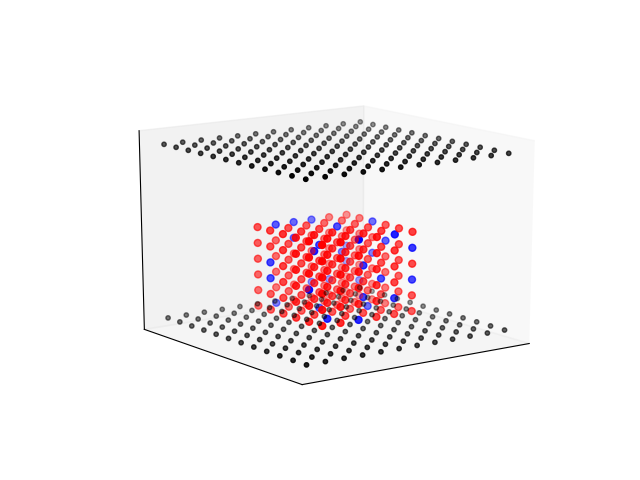

In [21]:
block, Alsites,Mgsites, Alcoords, Mgcoords = create_system(D=6, XAl=.15, mixed='y')
    # D should always be an even number
    # XAl is the concentration of Aluminum (some # between 0 and 1)
    # mixed: if 'y', then the blue atoms will be randomly mixed. If 'n' then they will start in a group




# Plotting stuff to visualize the system:
d,e,f = np.where(block == 4) # Plots the floor and ceiling of the box
mgx,mgy,mgz = Mgsites
alx,aly,alz = Alsites

%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(mgx,mgy,mgz, zdir='z', c= 'red',s=25)
ax.scatter(d,e,f, zdir='z', c= 'black',s=10)
ax.scatter(alx,aly,alz, zdir='z', c= 'blue',s=25)
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
plt.show()